## 네이버 영화 리뷰 감성 분류하기(Naver Movie Review Sentiment Analysis

이번에 사용할 데이터는 네이버 영화 리뷰 데이터입니다. 총 200,000개 리뷰로 구성된 데이터로 (앞서 실습한 IMDB 리뷰 데이터와 마찬가지로) 영화 리뷰에 대한 텍스트와 해당 리뷰가 긍정인 경우 1을 부정인 경우 0으로 표시한 레이블로 구성되어져 있습니다.

깃허브부터 해당 데이터를 다운로드 받아 감성 분류를 수행하는 모델을 만들어보겠습니다.

위의 링크에서 훈련 데이터에 해당하는** ratings_train.txt와** 테스트 데이터에 해당하는** ratings_test.txt를** 다운로드합니다. 또한 Pandas를 이용하여 훈련 데이터는 train_data에 테스트 데이터는 test_data에 저장합니다.


#### konlpy 설치

In [1]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [74.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:12 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:14 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic/main Sour

In [2]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import re
import konlpy
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

## txt파일 pandas로 불러와 df로 저장.

In [0]:
train_data= pd.read_table('ratings_train.txt')
test_data= pd.read_table('ratings_test.txt')

In [5]:
print(len(train_data)) # 리뷰 개수 출력

150000


In [6]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


상위 5개의 샘플만 출력해보았는데, 해당 데이터는 id, document, label 총 3개의 열로 구성되어져 있습니다. id는 감성 분류를 수행하는데 도움이 되지 않으므로 앞으로 무시합니다. 결국 이 모델은 리뷰 내용을 담고있는 document와 해당 리뷰가 긍정(1), 부정(0)인지를 나타내는 label 두 개의 열을 학습하는 모델이 될 겁니다.

또한 단지 상위 5개의 샘플만 출력해보았지만, 벌써 한국어 데이터와 영어 데이터의 차이를 확인할 수 있습니다. 예를 들어, 인덱스 2에 해당하는 세번째 샘플은 띄어쓰기를 하지 않아도 글을 쉽게 이해할 수 있는 한국어의 특성으로 인해 띄어쓰기가 전혀 되어있지 않습니다. 이제 test_data의 개수와 상위 5개의 샘플을 확인해봅시다.

In [7]:
print(len(test_data))

50000


test_data도 train_data와 동일한 형식으로 id, document, label 3개의 열로 구성되어져 있습니다. train_data에 대한 전처리 과정을 정하고 나면, test_data에도 동일한 전처리 과정을 적용하면 될 것 같습니다. 다시 train_data의 이야기로 돌아가봅시다. train_data에서 해당 리뷰의 긍, 부정 유무가 기재되어있는 레이블(label) 값의 분포를 보도록 하겠습니다.

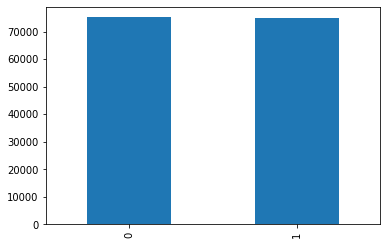

In [8]:
train_data['label'].value_counts().plot(kind='bar')

앞서 확인하였듯이 150,000개의 영화 리뷰 샘플이 존재하는데 그래프 상으로 긍정과 부정 둘 다 약 75,000개의 샘플이가 존재하여 레이블의 분포가 균일한 것처럼 보입니다. 정확하게 몇 개인지 확인하고 싶다면 아래의 코드를 수행하면 됩니다.

In [9]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  75173
1      1  74827


레이블이 0인 리뷰가 근소하게 많습니다. 리뷰 중에 Null 값을 가진 샘플이 있는지는 Pandas의 isnull().values.any()로 확인합니다.

In [10]:
print(train_data.isnull().values.any())

True


True가 나왔다면 데이터 중에 Null 값을 가진 샘플이 존재한다는 의미입니다. 어떤 열에 존재하는지 확인해봅시다.

In [11]:
print(train_data.isnull().sum())

id          0
document    5
label       0
dtype: int64


리뷰가 적혀있는 document 열에서 Null 값을 가진 샘플이 총 5개가 존재한다고 합니다. 그렇다면 document 열에서 Null 값이 존재한다는 것을 조건으로 Null 값을 가진 샘플이 어느 인덱스의 위치에 존재하는지 한 번 출력해봅시다.

In [12]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


##  Null 값을 가진 샘플을 제거하도록 하겠습니다.

In [13]:
train_data=train_data.dropna(how='any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [14]:
print(len(train_data))

149995


이제 데이터의 전처리를 수행해보겠습니다. 위의 train_data와 test_data에서 온점(.)이나 ?와 같은 각종 특수문자가 사용된 것을 확인했습니다. train_data로부터 한글만 남기고 제거하기 위해서 정규 표현식을 사용해보겠습니다.

우선 한글이 아니라 영어의 경우를 상기해보겠습니다. 영어의 알파벳들을 나타내는 정규 표현식은 [a-zA-Z]입니다. 이 정규 표현식은 영어의 소문자와 대문자들을 모두 포함하고 있는 정규 표현식으로 이를 응용하면 영어에 속하지 않는 구두점이나 특수문자를 제거할 수 있습니다. 예를 들어 알파벳과 공백을 제외하고 모두 제거하는 전처리를 수행하는 예제는 다음과 같습니다.

## 정규표현식으로 전처리, 한글과 공백을 제외하고 모두 제거(레이블도삭제되서 xtrain만드는 과정이기도함)

In [15]:
text='do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
re.sub(r'[^a-zA-Z ]', '', text) #알파벳과 공백을 제외하고 모두 제거

'do you expect people to read the FAQ etc and actually accept hard atheism'

위와 같은 원리를 한국어 데이터에 적용하고 싶다면, 우선 한글을 범위 지정할 수 있는 정규 표현식을 찾아내면 되겠습니다. 우선 자음과 모음에 대한 범위를 지정해보겠습니다. 일반적으로 자음의 범위는 ㄱ ~ ㅎ, 모음의 범위는 ㅏ ~ ㅣ와 같이 지정할 수 있습니다. 해당 범위 내에 어떤 자음과 모음이 속하는지 알고 싶다면 아래의 링크를 참고하시기 바랍니다.

https://www.unicode.org/charts/PDF/U3130.pdf
ㄱ ~ ㅎ: 3131 ~ 314E
ㅏ ~ ㅣ: 314F ~ 3163

또한 완성형 한글의 범위는 가 ~ 힣과 같이 사용합니다. 해당 범위 내에 포함된 음절들은 아래의 링크에서 확인할 수 있습니다.
https://www.unicode.org/charts/PDF/UAC00.pdf

위의 범위 지정을 모두 반영하여 train_data에 한글과 공백을 제외하고 모두 제거하는 정규 표현식을 수행해봅시다.

In [16]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


상위 5개의 샘플을 다시 출력해보았는데, 정규 표현식을 수행하자 기존의 공백. 즉, 띄어쓰기는 유지되면서 온점과 같은 구두점 등은 제거되었습니다.

이제 토큰화와 불용어 제거를 해보도록 하겠습니다. 불용어는 정의하기 나름인데, 한국어의 조사, 접속사 등의 보편적인 불용어를 사용할 수도 있겠지만 결국 풀고자 하는 문제의 데이터를 지속 검토하면서 계속해서 추가하는 경우 또한 많습니다. 실제 현업인 상황이라면 일반적으로 아래의 불용어보다 더 많은 불용어를 사용하기도 합니다.

In [0]:
stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

여기서는 위 정도로만 불용어를 정의하고, 토큰화를 위한 형태소 분석기는 KoNLPy의 Okt를 사용합니다. 잠시 Okt를 복습해봅시다.

In [18]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem=True)

/usr/local/lib/python3.6/dist-packages/jpype/_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

Okt는 위와 같이 KoNLPy에서 제공하는 형태소 분석기입니다. 한국어을 토큰화할 때는 영어처럼 띄어쓰기 기준으로 토큰화를 하는 것이 아니라, 주로 형태소 분석기를 사용한다고 언급한 바 있습니다. stem=True를 사용하면 일정 수준의 정규화를 수행해주는데, 예를 들어 위의 예제의 결과를 보면 '이런'이 '이렇다'로 변환되었고 '만드는'이 '만들다'로 변환된 것을 알 수 있습니다.

이제 train_data에 형태소 분석기를 사용하여 토큰화를 하면서 불용어를 제거하여 X_train에 저장합니다.

## 토큰화 및 불용어제거

In [0]:
X_train=[]
for sentence in train_data['document']:
    temp_X = []
    temp_X=okt.morphs(sentence, stem=True) # 토큰화
    temp_X=[word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [20]:
print(X_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [0]:
test_data=test_data.dropna(how='any') # Null 값 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행

X_test=[]
for sentence in test_data['document']:
    temp_X = []
    temp_X=okt.morphs(sentence, stem=True) # 토큰화
    temp_X=[word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

지금까지 훈련 데이터와 테스트 데이터에 대해서 텍스트 전처리를 진행해보았습니다. 이제 기계가 데이터를 숫자로서 처리할 수 있도록 훈련 데이터 X_train과 테스트 데이터 X_test에 대해서 정수 인코딩을 수행합니다.

In [0]:
max_words = 35000
tokenizer = Tokenizer(num_words=max_words) # 상위 35,000개의 단어만 보존
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [23]:
print(X_train[:3])

[[50, 457, 16, 260, 660], [919, 459, 41, 599, 1, 214, 1455, 24, 965, 676, 19], [386, 2452, 25024, 2319, 5676, 2, 221, 9]]


리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.64700156671889


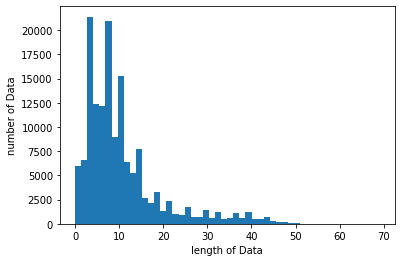

In [24]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [0]:
max_len=30
# 전체 데이터의 길이는 30으로 맞춘다.
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [0]:
y_train=np.array(train_data['label'])
y_test=np.array(test_data['label'])

## 2. LSTM으로 네이버 영화 리뷰 감성 분류하기
이제 본격적으로 모델을 만들어봅시다.

In [0]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential

In [29]:
model = Sequential()
model.add(Embedding(max_words, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=4, batch_size=60, validation_split=0.2)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 119996 samples, validate on 29999 samples
Epoch 1/4
119996/119996 [==============================] - 138s 1ms/sample - loss: 0.3893 - acc: 0.8211 - val_loss: 0.3521 - val_acc: 0.8396
Epoch 2/4
119996/119996 [==============================] - 135s 1ms/sample - loss: 0.3289 - acc: 0.8561 - val_loss: 0.3345 - val_acc: 0.8517
Epoch 3/4
119996/119996 [==============================] - 134s 1ms/sample - loss: 0.3024 - acc: 0.8707 - val_loss: 0.3289 - val_acc: 0.8573
Epoch 4/4
119996/119996 [==============================] - 133s 1ms/sample - loss: 0.2806 - acc: 0.8835 - val_loss: 0.3316 - val_acc: 0.8549


In [31]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

49997/49997 [==============================] - 23s 463us/sample - loss: 0.3391 - acc: 0.8511

 테스트 정확도: 0.8511


In [30]:
X_test[:2]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 644,  87],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]], dtype=int32)

## 모델 사용해보기


https://cyc1am3n.github.io/2018/11/10/classifying_korean_movie_review.html